# Supervised ML - Bike Sharing


This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered


In [ ]:
urllink = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'

zipName = urllink.split('/')[-1]

In [6]:
from urllib.request import urlopen

# open and save the zip file onto computer
url = urlopen(urllink)
output = open(zipName, 'wb')    # note the flag:  "wb"        
output.write(url.read())
output.close()

from zipfile import ZipFile
# read zipfile and extract, then close
zipfile = ZipFile(zipName,'r')
ziplist = zipfile.namelist()
print(ziplist)

zipfile.extractall()
zipfile.close()

['Readme.txt', 'day.csv', 'hour.csv']


In [31]:
import pandas as pd

# read file
'''
df_day = pd.read_csv('day.csv')
print(df_day.columns)
print(df_day.shape)
'''
df_hour = pd.read_csv('hour.csv')
print(df_hour.columns)
print(df_hour.shape)


Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')
(17379, 17)


In [45]:
# temp : Normalized temperature in Celsius. 
# The values are derived via (t-t_min)/(t_max-t_min)
# t_min=-8, t_max=+39 (only in hourly scale)

def temp_Celcius(norm_t):
    t_min=-8
    t_max=+39
    return norm_t * (t_max-t_min) + t_min

df_hour['temp_Celcius'] = temp_Celcius(df_hour['temp'])

### Plotting bike count versus temperature 

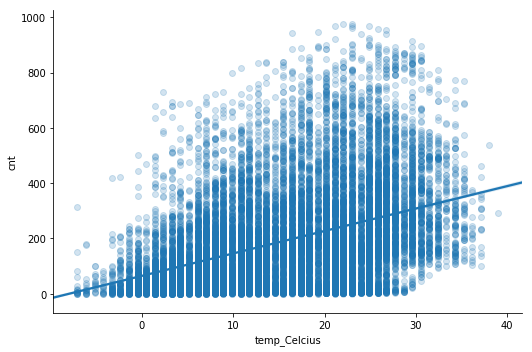

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

df_hour.plot(kind='scatter', x='temp_Celcius', y='cnt', alpha=0.2);

import seaborn as sns

#using seaborn to get a line of best fit
sns.lmplot(x='temp_Celcius', y='cnt', data=df_hour, aspect=1.5, scatter_kws={'alpha':0.2});

### Predicting for a single feature (LinearRegression)

In [50]:
# check the correlation between temperature and bike rent count
df_hour[['cnt', 'temp_Celcius']].corr()

,cnt,temp_Celcius
cnt,1.000000,0.404772
temp_Celcius,0.404772,1.000000


There is a weak and positive correlation between two variables.

Now, lets build a Linear Regression model within these two variables by using Scikit-Learn

In [68]:
# create X and y
feature_cols = ['temp_Celcius']      # a lsit of the predictors
X = df_hour[feature_cols]            # subsetting our data to only the predictors
y = df_hour['cnt']                   # our response variable

# import scikit-learn, our machine learning module
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()          # instantiate a new model
linreg.fit(X, y)                     # fit the model to our data

# print the coefficients
print(linreg.intercept_)             # count when temp=0
print(linreg.coef_)                  # count when temp increase 1 Celcius

import numpy as np

t = np.array([20,30,40])             # some temperatures to predict bike rent count
linreg.predict(t.reshape(-1, 1))

64.86566725062117
[8.11265792]


array([227.11882566, 308.24540486, 389.37198407])

### Predicting for multiple features (LinearRegression)

• temp_Celcius: Temperature in Celsius

• season: 1 = spring, 2 = summer, 3 = fall, 4 = winter

• weather:
1. Clear, Few clouds, Partly cloudy
2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

• hum: Relative humidity


In [79]:
# create a list of features
feature_cols = ['temp_Celcius', 'season', 'weathersit', 'hum']

# create X and y
X = df_hour[feature_cols]
y = df_hour['cnt']

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# pair the feature names with the coefficients
list(zip(feature_cols, linreg.coef_))

[('temp_Celcius', 6.968563688883241),
 ('season', 19.637825963625158),
 ('weathersit', 9.423299897252543),
 ('hum', -310.7772610685748)]

• When all other predictors constant, a 1 unit increase in temperature is associated with a rental increase of ~7 bikes

• When all other predictors constant, a 1 unit increase in season is associated with a rental increase of ~20 bikes

• When all other predictors constant, a 1 unit increase in weather is associated with a rental increase of ~9 bikes

• When all other predictors constant, a 1 unit increase in humidity is associated with a rental decrease of ~-310 (!) bikes

Now, lets look at the individual scatter plots between each predictor and the response. That is required to understand which of the predictors (features) would help to make the prediction, and which ones are just noise. To do so, some more advanced metrics should be used.


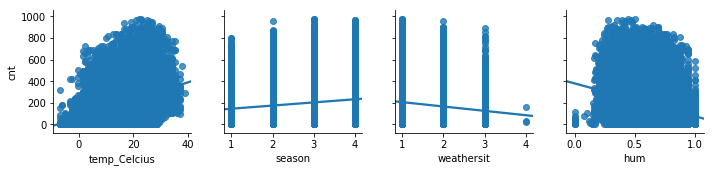

In [82]:
# multiple scatter plots
sns.pairplot(df_hour, x_vars=feature_cols, y_vars='cnt', kind='reg');